In [637]:
# https://github.com/fopina/pyspeedtest/blob/master/pyspeedtest.py
import pyspeedtest
import pymongo
from pymongo import MongoClient

from datetime import datetime
from datetime import timedelta

import os, sys
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

# Basic Checks

In [2]:
# -- Check for a proper Python Version
if sys.version[0:3] < '3.0':
    print ('Python version 3.0 or greater required (found: {0}).'.format(sys.version[0:5]))
    sys.exit(-1)
if pymongo.__version__[0:3] < '3.0':
    print ('pymongo version 3.0 or greater required (found: {0}).'.format(pymongo.__version__[0:5]))
    sys.exit(-1)

# Plot Methods

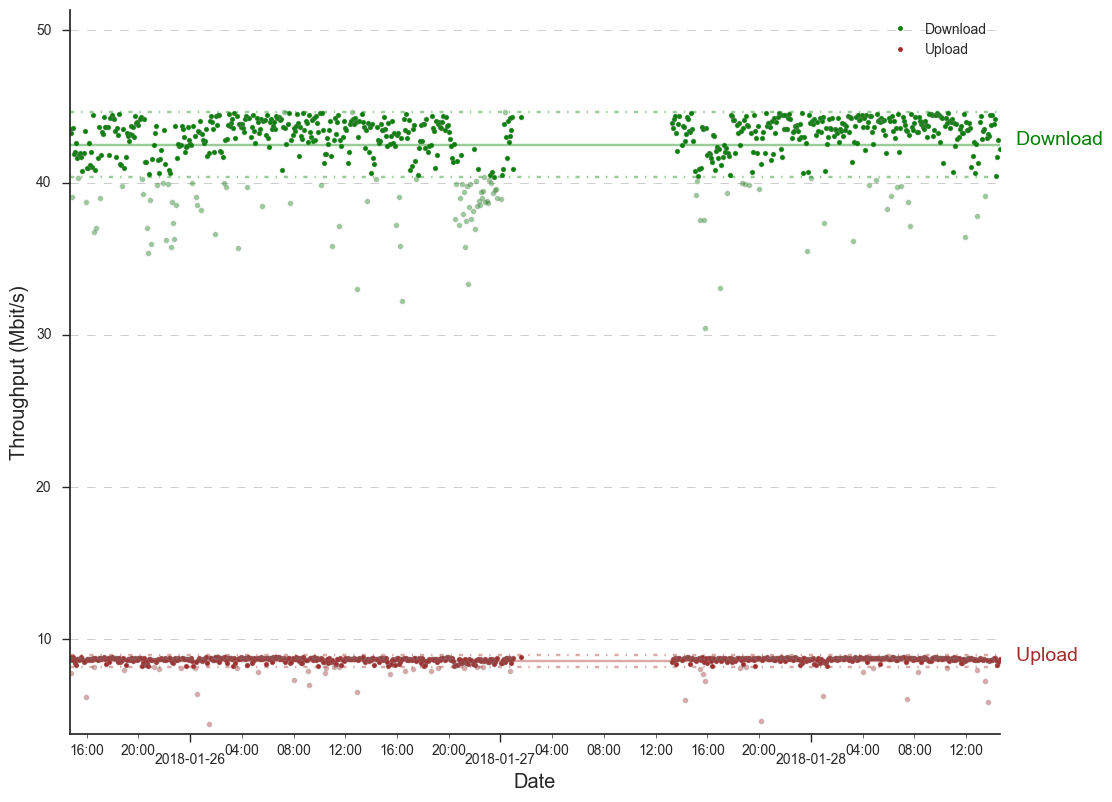

In [383]:
def plotGraph(df, dictLabel = {'y': "Throughput (Mbit/s)", 'x':"Date"}):
    """Plot route"""

    with sns.axes_style("ticks"):
        plt.figure(figsize=(12, 9))
        plt.subplots_adjust(hspace=0.001)

        plt.subplots_adjust(top=0.93)
    
        ax1 = plt.subplot(1, 1, 1)
        #ax1.grid(True)
        plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
        
        # Remove the plot frame lines
        ax1.spines['top'].set_visible(False)
        ax1.spines['bottom'].set_visible(True)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(True)

        # No ticks right and top
        ax1.get_xaxis().tick_bottom()
        ax1.get_yaxis().tick_left()
        
        plt.tick_params(axis='both', which='both', bottom='on', top='off',
                labelbottom='on', left='on', right='off', labelleft='on')

        
        fields = {'upload': "Upload",  
                  'download': "Download"}

        colors = ["green", "brown"]
        markers = [".", "."]
           
        pltList = []
        for rank, (key, value) in enumerate(fields.items()): 
            mean = df[key].mean() 
            std  = df[key].std() 

            # Seperate Plot sets
            dfx_out = df[ ((df[key] < mean-std) | (df[key] > mean+std))]
            dfx_in  = df[~((df[key] < mean-std) | (df[key] > mean+std))]

            # Plot inside STD
            plt1, = ax1.plot_date(x=dfx_in.index, y=dfx_in[key], label=value, markersize=7,
                                    color=colors[rank], fmt=markers[rank])
            pltList.append(plt1)
            
            # Plot outside STD
            plt1, = ax1.plot_date(x=dfx_out.index, y=dfx_out[key], label=value, markersize=7,
                                    color=colors[rank], fmt=markers[rank], alpha=0.4)
            # Plot circle
            plt1, = ax1.plot_date(x=df.index, y=df[key], label=value,
                                    fmt=markers[rank], alpha=0.2,markersize=7,
                                    markerfacecolor='none', markeredgewidth=1, markeredgecolor='grey')

            # Add Label on right side
            plt.text(df.index[-1], mean, "   {}".format(fields[key]), fontsize=14, color=colors[rank])
            
            # Add horizontal lines
            x1, x2 = ax1.get_xlim()
            plt.plot((x1, x2), (mean, mean), '-', color=colors[rank], alpha=0.4)
            plt.plot((x1, x2), (mean+std, mean+std), '-.', color=colors[rank], alpha=0.4)
            plt.plot((x1, x2), (mean-std, mean-std), '-.', color=colors[rank], alpha=0.4)
                        
        # Set x-axis
        plt.xlabel(dictLabel['x'], fontsize='large')
    
        fmt = mdates.DateFormatter('%Y-%m-%d')
        loc = mdates.DayLocator()
        fmtx = mdates.DateFormatter('%H:%M')
        locx = mdates.HourLocator(byhour=[4,8,12,16,20])

        ax1.xaxis.set_major_formatter(fmt)
        ax1.xaxis.set_major_locator(loc)
        ax1.xaxis.set_minor_formatter(fmtx)
        ax1.xaxis.set_minor_locator(locx) 
    
        # Set y-axis
        total_min = min([df[key].min() for key in fields.keys()])
        total_max = max([df[key].max() for key in fields.keys()])
        ax1.set(ylim=(total_min*0.85, total_max*1.15))
        plt.ylabel(dictLabel['y'], fontsize='large')
           
        # Legend
        plt.legend(handles=pltList, loc=1)
 
        plt.show()
    
plotGraph(df)

# MongoDb

In [3]:
MONGO_SERVER  = '192.168.178.38'
MONGO_DB_NAME = 'SpeedTest'

ADMIN_USER    = 'user_ST_rw'
READONLY_USER = 'user_ST_ro'

COLLECTION_INDICES = {'Location': 'date'}

In [4]:
# ----------------------------------------------------------------------------------
class mongoDbUtil:
    """Class to connect to mongoDB and perform actions."""

    # _________________________________________________________
    def __init__(self, args, user = 'none'):
        self.args = args

        # -- Get the password form env
        if user == "none":
            self.user = None
            self.password = ""
        elif user == "admin":
            self.user = ADMIN_USER
            self.password = os.getenv(ADMIN_USER, 'empty')
        else:
            self.user = READONLY_USER
            self.password = os.getenv(READONLY_USER, 'empty')

        if self.password == 'empty':
            print("Password for user {0} at database {1} has not been supplied".format(self.user, MONGO_DB_NAME))
            sys.exit(-1)

        self.today = datetime.today().strftime('%Y-%m-%d')

        # -- Connect
        self._connectDB()

    # _________________________________________________________
    def _connectDB(self):
        """Connect to the NERSC mongoDB using pymongo."""

        if self.user is None:
            self.client = MongoClient('mongodb://{}/{}'.format(MONGO_SERVER, MONGO_DB_NAME))
        else:
            self.client = MongoClient('mongodb://{0}:{1}@{2}/{3}?authSource=admin'.format(self.user, self.password,
                                                                         MONGO_SERVER, MONGO_DB_NAME))

        self.db = self.client[MONGO_DB_NAME]
        # print ("Existing collections:", self.db.collection_names(include_system_collections = False))

    # _________________________________________________________
    def close(self):
        """Close conenction to the NERSC mongoDB using pymongo."""

        self.client.close()
        self.db = ""

    # _________________________________________________________
    def getCollection(self, collectionName = 'DefaultLocation'):
        """Get collection and set index."""

        collection = self.db[collectionName]

        # - For all locations
        if collectionName not in COLLECTION_INDICES:
            coll_index = 'date'

            return collection

        try:
            collection.create_index([(COLLECTION_INDICES[collectionName], pymongo.ASCENDING)], unique=True)
        except KeyError:
            print ("Warning: Collection", collectionName, "not known. Index not created.")
            pass

        return collection

    # _________________________________________________________
    def dropCollection(self, collectionName):
        """Drop collection."""

        self.db[collectionName].drop()


## Connect MongoDb

In [592]:
dbUtil = mongoDbUtil("","admin")

In [593]:
coll = dbUtil.getCollection("Vogelsbergstrasse_24a")
coll

Collection(Database(MongoClient(host=['192.168.178.38:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin'), 'SpeedTest'), 'Vogelsbergstrasse_24a')

## Get Data

In [594]:
# Select Interval
dateInterval = [datetime.now(), datetime.now() - timedelta(days=3)]

In [595]:
# Create query

In [596]:
query = {'date': {"$lt": dateInterval[0]},
         'date': {"$gt": dateInterval[1]},
         'runs':10}

In [597]:
# Retrieve data fm 
entries = [item for item in coll.find(query)]

In [610]:
df = pd.DataFrame.from_records(entries)
df.set_index(['date'],inplace=True)

df['download'] = df['download']/(1024*1024)
df['upload'] = df['upload']/(1024*1024)

In [611]:
df.head()

,_id,download,ping,runs,server,upload
date,,,,,,
2018-01-26 00:50:20.446,5a6a6d3c8a0ffd414168ee88,38.197279,17.755568,10,speed.23media.de,8.669744
2018-01-26 00:55:19.019,5a6a6e678a0ffd418d83a86f,43.191805,17.435312,10,speed.23media.de,8.588112
2018-01-26 01:00:19.675,5a6a6f938a0ffd41d62c2928,42.815439,17.421544,10,speed.23media.de,8.689641
2018-01-26 01:05:21.214,5a6a70c18a0ffd421f51fafa,42.602765,17.638624,10,s1.fra.speedtest.interoute.net,8.639447
2018-01-26 01:10:18.744,5a6a71ea8a0ffd4269be6270,42.751275,17.583013,10,s1.speedtest.fra1.de.leaseweb.net,8.796679


In [612]:
df['server'].unique()

array(['speed.23media.de', 's1.fra.speedtest.interoute.net',
       's1.speedtest.fra1.de.leaseweb.net', 'speedtest.vodafone-ip.de',
       'sp1.mbn-glasfaser.de'], dtype=object)

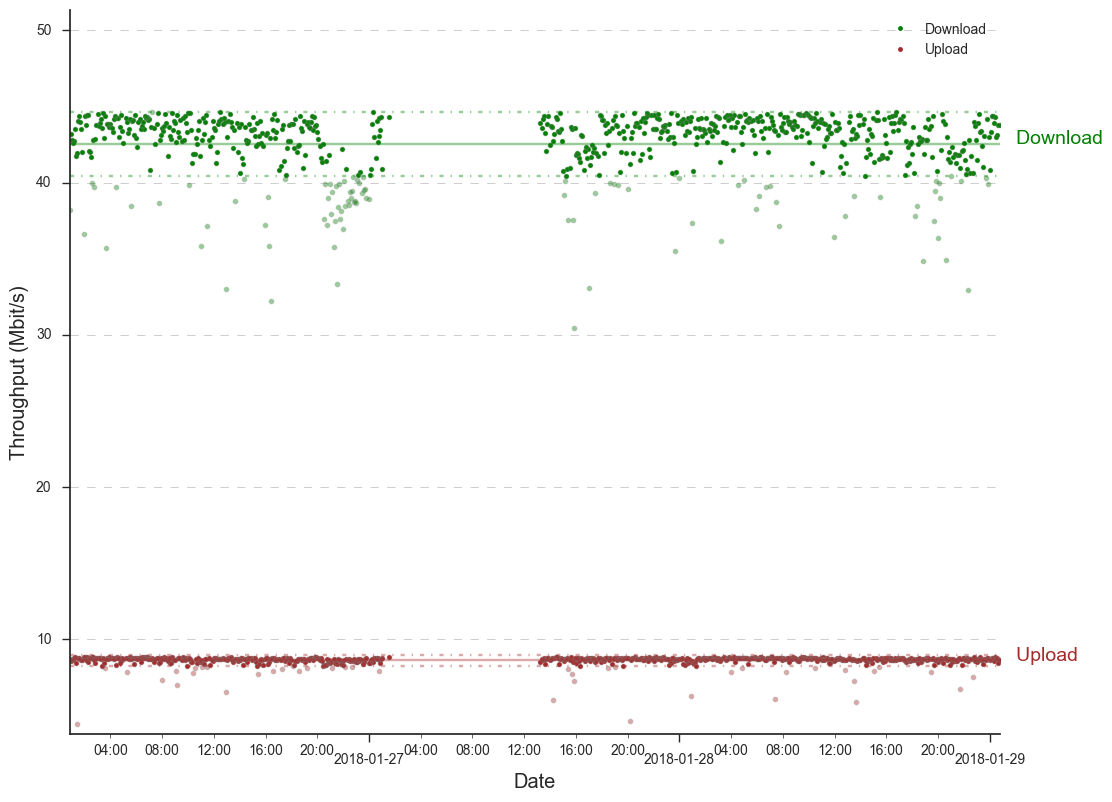

In [613]:
plotGraph(df)

In [614]:
df['download'].std()

2.0996384874087681

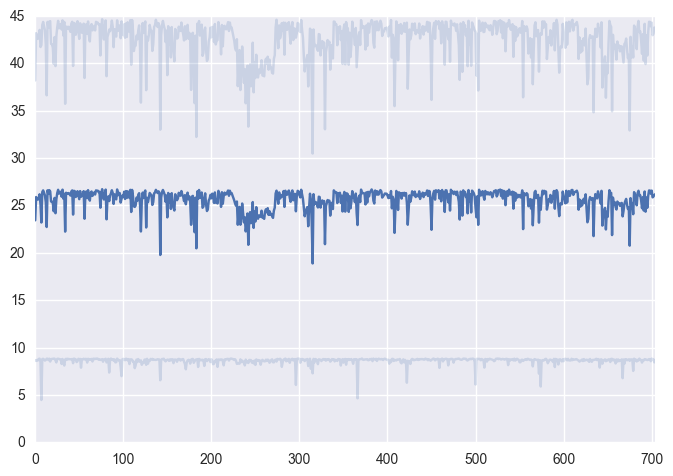

In [615]:
# plot time series with seaborn
ax = sns.tsplot(data=[df['upload'],df['download']], err_style="unit_traces")

# Add std deviation bars to the previous plot
mean = df.mean(axis=1)
std  = df.std(axis=1)
#ax.errorbar(x=df.index, y=mean, yerr=std) #fmt=None to plot bars only

plt.show()

In [616]:
import seaborn.timeseries

def _plot_std_bars(*args, central_data=None, ci=None, data=None, **kwargs):
    std = data.std(axis=0)
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_bars(*args, **kwargs)

def _plot_std_band(*args, central_data=None, ci=None, data=None, **kwargs):
    std = data.std(axis=0)
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    seaborn.timeseries._plot_ci_band(*args, **kwargs)

seaborn.timeseries._plot_std_bars = _plot_std_bars
seaborn.timeseries._plot_std_band = _plot_std_band

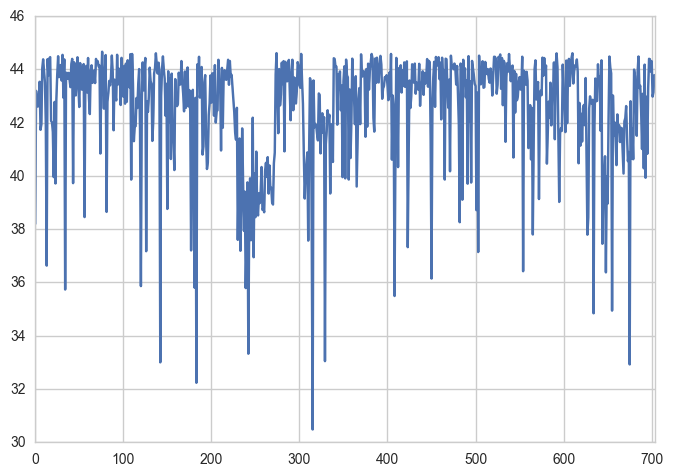

In [638]:
ax = sns.tsplot(df['download'], err_style="std_band", n_boot=0)

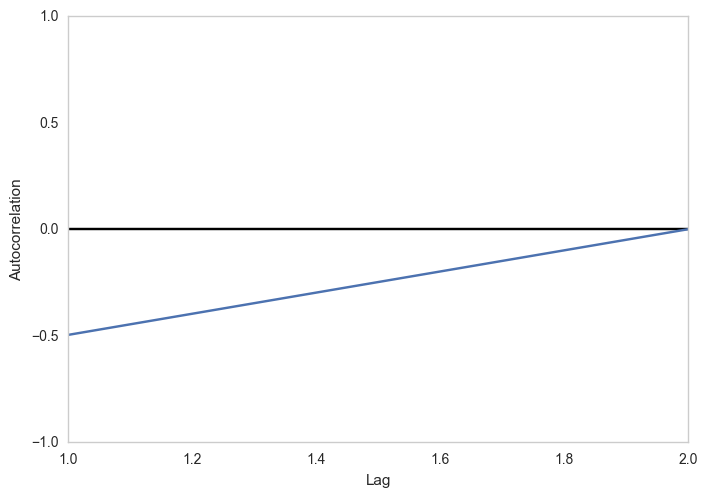

In [639]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot([df['upload'], df['download']])

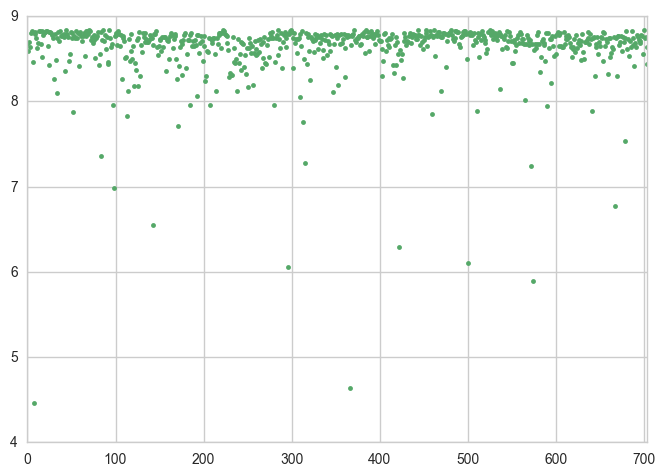

In [640]:
df['upload'].plot(style="g.")

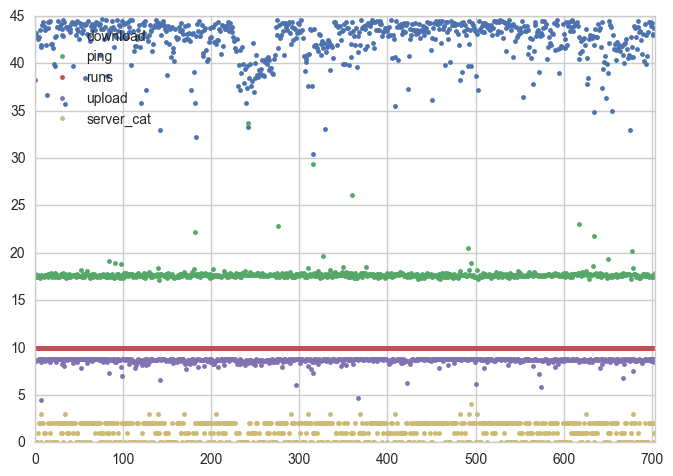

In [641]:
df.plot(style=".")

In [642]:



days = DataFrame()
for name, group in groups:
    days[name.day] = group.values
years.plot(subplots=True, legend=False)
pyplot.show()

NameError: name 'DataFrame' is not defined

In [643]:
days = DataFrame()
for name, group in groups:
    years[name.minute] = group.values
    years.plot(subplots=True, legend=False)
    pyplot.show()
    print(name.day)

NameError: name 'DataFrame' is not defined

In [644]:
df.head()

,date,_id,download,ping,runs,server,upload,server_cat
0,2018-01-26 00:50:20.446,5a6a6d3c8a0ffd414168ee88,38.197279,17.755568,10,speed.23media.de,8.669744,0
1,2018-01-26 00:55:19.019,5a6a6e678a0ffd418d83a86f,43.191805,17.435312,10,speed.23media.de,8.588112,0
2,2018-01-26 01:00:19.675,5a6a6f938a0ffd41d62c2928,42.815439,17.421544,10,speed.23media.de,8.689641,0
3,2018-01-26 01:05:21.214,5a6a70c18a0ffd421f51fafa,42.602765,17.638624,10,s1.fra.speedtest.interoute.net,8.639447,1
4,2018-01-26 01:10:18.744,5a6a71ea8a0ffd4269be6270,42.751275,17.583013,10,s1.speedtest.fra1.de.leaseweb.net,8.796679,2


In [645]:
from pandas import Grouper
groups = df['upload'].groupby(pd.Grouper(freq='D'))

days = pd.DataFrame()
for name, group in groups:
    
    days[name] = group.values
days.plot(subplots=True, legend=False)
plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

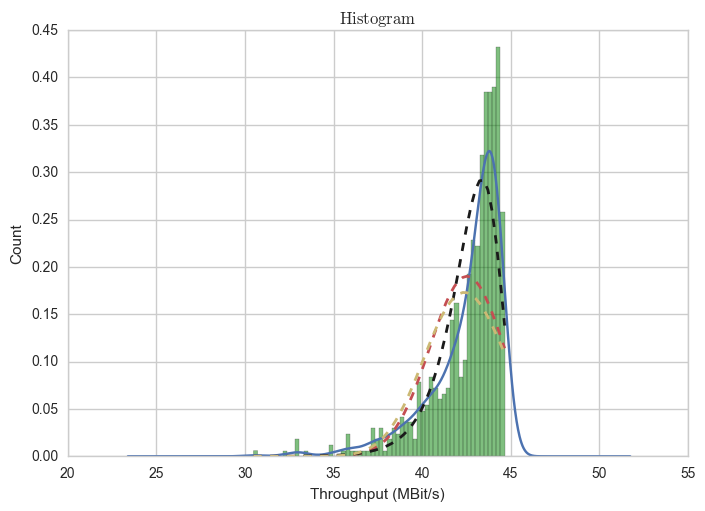

In [646]:
from scipy.stats import norm
from scipy.stats import gumbel_l
from scipy.stats import gamma

# the histogram of the data
n, bins, patches = plt.hist(df['download'], 60, normed=1, facecolor='green', alpha=0.5)

df['download'].plot(kind='kde', color='b')

# best fit of data
(mu, sigma) = norm.fit(df['download'])
(a,b) = gumbel_l.fit(df['download'])
(c,d, e) = gamma.fit(df['download'])

#z = mlab.normpdf( bins, a, b)
z = gumbel_l.pdf( bins, a, b)

zz = gamma.pdf( bins, c,d,e)


# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
ll = plt.plot(bins, z, 'k--', linewidth=2)
lll = plt.plot(bins, zz, 'y--', linewidth=2)


plt.xlabel('Throughput (MBit/s)')
plt.ylabel('Count')
plt.title(r'$\mathrm{Histogram}\ $')
plt.grid(True)

plt.show()

In [647]:
serverList = df['server'].unique() 
df['server_cat'] = pd.Categorical(df.loc[:,'server'], serverList)
df.loc[:,'server_cat'] = df['server_cat'].cat.codes

In [648]:
df.head()

,date,_id,download,ping,runs,server,upload,server_cat
0,2018-01-26 00:50:20.446,5a6a6d3c8a0ffd414168ee88,38.197279,17.755568,10,speed.23media.de,8.669744,0
1,2018-01-26 00:55:19.019,5a6a6e678a0ffd418d83a86f,43.191805,17.435312,10,speed.23media.de,8.588112,0
2,2018-01-26 01:00:19.675,5a6a6f938a0ffd41d62c2928,42.815439,17.421544,10,speed.23media.de,8.689641,0
3,2018-01-26 01:05:21.214,5a6a70c18a0ffd421f51fafa,42.602765,17.638624,10,s1.fra.speedtest.interoute.net,8.639447,1
4,2018-01-26 01:10:18.744,5a6a71ea8a0ffd4269be6270,42.751275,17.583013,10,s1.speedtest.fra1.de.leaseweb.net,8.796679,2


In [649]:
dfx = df[['download','upload','ping','server_cat']]

In [650]:
dfx.head()

,download,upload,ping,server_cat
0,38.197279,8.669744,17.755568,0
1,43.191805,8.588112,17.435312,0
2,42.815439,8.689641,17.421544,0
3,42.602765,8.639447,17.638624,1
4,42.751275,8.796679,17.583013,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c5d8c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12dedab70>]], dtype=object)

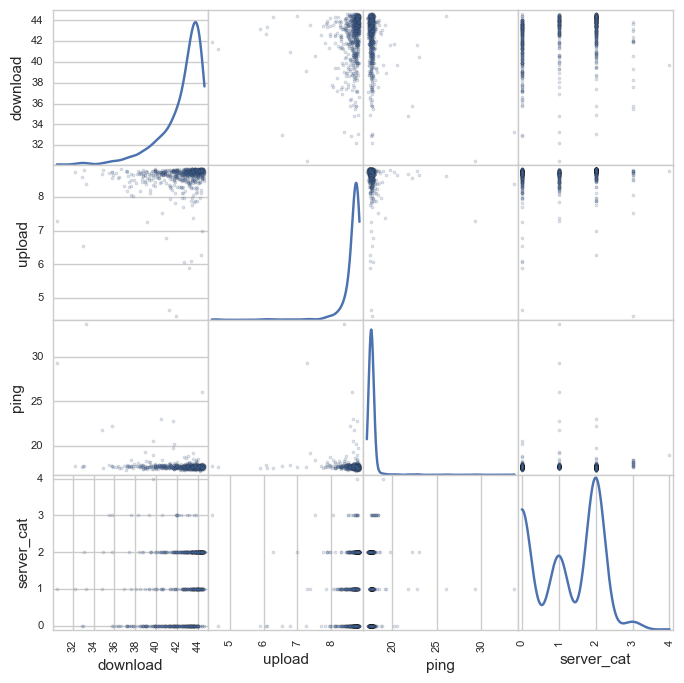

In [651]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(dfx, alpha=0.2, figsize=(8, 8), diagonal='kde')

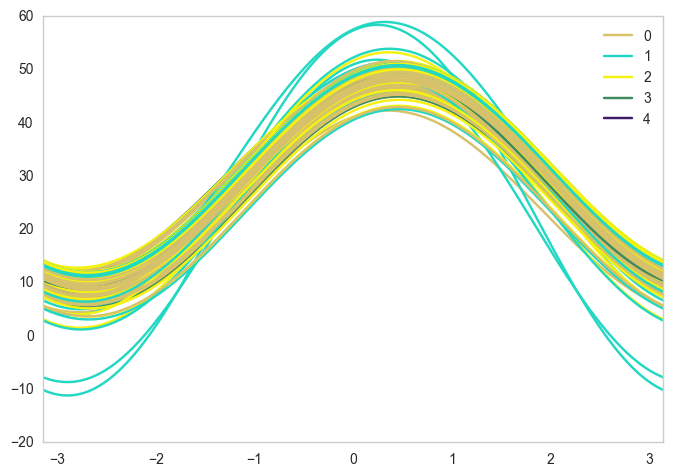

In [652]:
from pandas.tools.plotting import andrews_curves
plt.figure()
andrews_curves(dfx, 'server_cat')

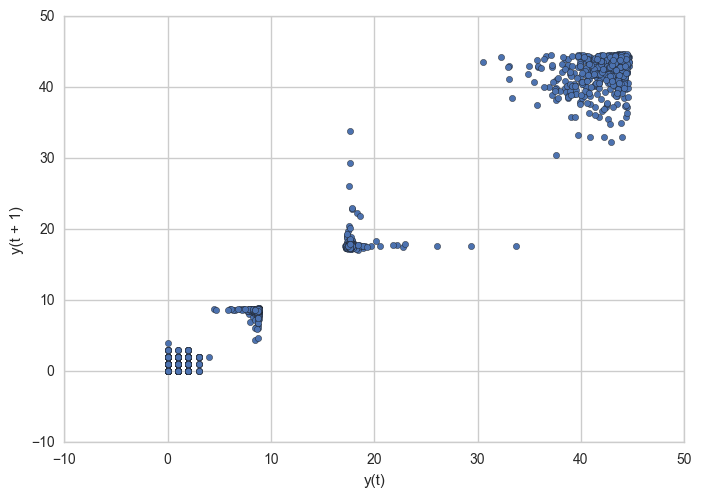

In [653]:
from pandas.tools.plotting import lag_plot
plt.figure()
lag_plot(dfx)

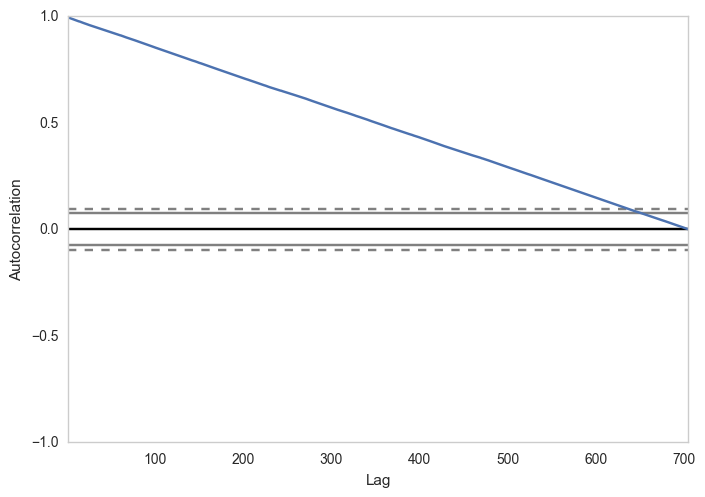

In [654]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure()
autocorrelation_plot(dfx)

In [655]:
df.reset_index(inplace=True)

df.head()

,index,date,_id,download,ping,runs,server,upload,server_cat
0,0,2018-01-26 00:50:20.446,5a6a6d3c8a0ffd414168ee88,38.197279,17.755568,10,speed.23media.de,8.669744,0
1,1,2018-01-26 00:55:19.019,5a6a6e678a0ffd418d83a86f,43.191805,17.435312,10,speed.23media.de,8.588112,0
2,2,2018-01-26 01:00:19.675,5a6a6f938a0ffd41d62c2928,42.815439,17.421544,10,speed.23media.de,8.689641,0
3,3,2018-01-26 01:05:21.214,5a6a70c18a0ffd421f51fafa,42.602765,17.638624,10,s1.fra.speedtest.interoute.net,8.639447,1
4,4,2018-01-26 01:10:18.744,5a6a71ea8a0ffd4269be6270,42.751275,17.583013,10,s1.speedtest.fra1.de.leaseweb.net,8.796679,2


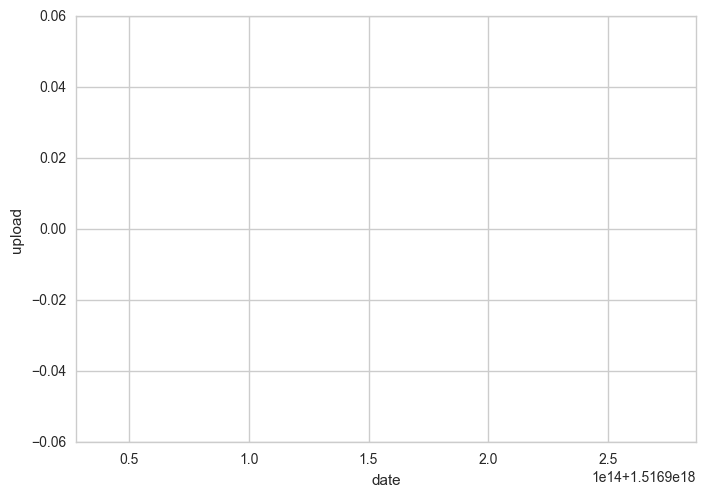

In [656]:
ax = sns.tsplot(data=df, time='date', value='upload')

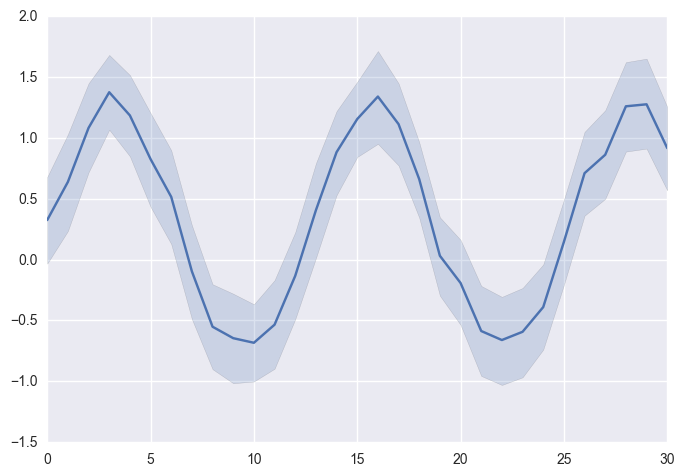

In [657]:
import numpy as np; np.random.seed(22)
import seaborn as sns; sns.set(color_codes=True)
x = np.linspace(0, 15, 31)
data = np.sin(x) + np.random.rand(10, 31) + np.random.randn(10, 1)
ax = sns.tsplot(data=data)

In [561]:
gammas = sns.load_dataset("gammas")


In [562]:
gammas.head()

,timepoint,ROI,subject,BOLD signal
0,0.0,IPS,0,0.513433
1,0.0,IPS,1,-0.414368
2,0.0,IPS,2,0.214695
3,0.0,IPS,3,0.814809
4,0.0,IPS,4,-0.894992
